In [11]:
import numpy as np
import sys
sys.path.append('./../gp_sinkhorn/')
from SDE_solver import solve_sde_RK
from utils import plot_trajectories_2
import matplotlib.pyplot as plt
from MLE_drift import *
import torch

from celluloid import Camera
from IPython.display import HTML
import math

from functools import partial
import pyro
from pyro.contrib.gp.kernels import Exponential, Matern32, RBF, Brownian, Combination, Product, Sum

# Double well

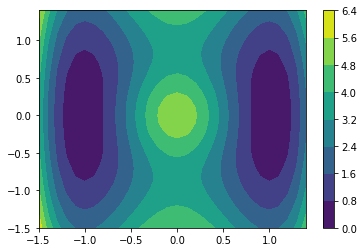

In [13]:
feature_x = np.arange(-1.5, 1.5, 0.1)
feature_y = np.arange(-1.5, 1.5, 0.1)
x, y = np.meshgrid(feature_x, feature_y)

delta = 0.35
fac = 1
fac_ = 1
z = (fac_*5/2.0)*(x**2-1)**2+y**2 +  fac*np.exp(-(  x**2 +y**2)/delta)/delta
 

#  -2 *x/delta*np.exp(-(  x**2 +y**2)/delta)/delta
#  (-( 2*y)/delta )*np.exp(-(  x**2 +y**2)/delta)/delta

h = plt.contourf(feature_x,feature_y,z)
plt.colorbar()
plt.show()



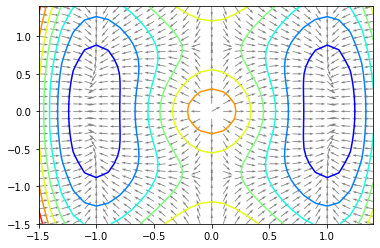

In [14]:
u = -(fac_*10*x*(x**2-1)) + fac* 2 * x * np.exp(-(  x**2 +y**2)/delta)/delta**2
v = -(2*y)  + fac * 2* y * np.exp(-(  x**2 +y**2)/delta)/delta**2

norm = np.linalg.norm(np.array((u, v)), axis=0)
u = (u / norm)*0.1
v = (v / norm)*0.1

fig, ax = plt.subplots(1, 1)

ax.quiver(x, y, u, v, units='xy', scale=1, color='gray')
ax.contour(x, y, z, 7, cmap='jet')


In [15]:
delta_tn = torch.tensor(delta)

deriv_x = lambda x,y: -(fac_ * 10*x*(x**2-1)) +  2 * x * torch.exp(-(  x**2 +y**2)/delta_tn)/delta_tn**2
deriv_y = lambda x,y: -(2*y) +2* y * torch.exp(-(  x**2 +y**2)/delta_tn)/delta_tn**2
# deriv_y = deriv_x
# prior_drift = lambda X: torch.tensor([[deriv_x(i[0]),deriv_y(i[1])] for i in X])

prior_drift = lambda X: torch.tensor([[deriv_x(i[0],i[1]),deriv_y(i[0],i[1])] for i in X])

In [16]:
num_samples=100
sigma = 0.5
dt = 0.02
N = int(math.ceil(1.0/dt))
mu_0 = torch.tensor([1.0,0.0])

eye_ = torch.diag(torch.tensor([0.25,3]))
X_0 = torch.distributions.multivariate_normal.MultivariateNormal(mu_0, eye_*0.05).sample((num_samples,1)).reshape((-1,2)).double()
mu_1 = torch.tensor([-1.0,0.0])
X_1 = torch.distributions.multivariate_normal.MultivariateNormal(mu_1,eye_ * 0.05).sample((num_samples,1)).reshape((-1,2)).double()

mu_2 = torch.tensor([0.0,0.0])
X_2 = torch.distributions.multivariate_normal.MultivariateNormal(mu_2,torch.eye(2)*0.5).sample((250,1)).reshape((-1,2))

prior_X_0 = X_2.double()
t, Xts = solve_sde_RK(b_drift=prior_drift,sigma=sigma, X0=prior_X_0, dt=dt, N=N)
#plot_trajectories_2(Xts, t, remove_time=True)

In [ ]:

t, Xts = solve_sde_RK(b_drift=prior_drift,sigma=sigma, X0=torch.cat((X_1, X_0)), dt=dt, N=N)
fig = plt.figure()
camera = Camera(fig)
for i in range(N):    
    plt.contourf(feature_x,feature_y,z)
    plt.scatter(Xts[:,i,0].detach(),Xts[:,i,1].detach())
    camera.snap()
animation = camera.animate()
HTML(animation.to_html5_video())
#animation.save('animation.mp4')



In [8]:
def kern_mix_1(input_dim, variance=None):
    return pyro.contrib.gp.kernels.Exponential(
            input_dim=3,
            lengthscale=torch.tensor(0.5),
            active_dims=[0,1,2]
        )

result = MLE_IPFP(
    X_0,X_1,N=N,sigma=0.5,
    prior_drift=prior_drift,
    prior_X_0=prior_X_0, iteration=5, refinement_iterations=0,
    decay_sigma=1, gp_mean_prior_flag=False, kernel=kern_mix_1, nn=False
)

  0%|                                                                                            | 0/5 [00:00<?, ?it/s] ./../gp_sinkhorn\MLE_drift.py:253: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 ./../gp_sinkhorn\MLE_drift.py:277: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [09:52<00:00, 118.56s/it]


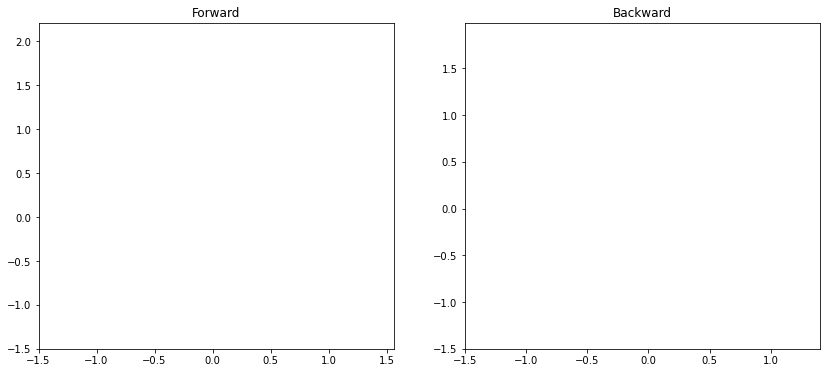

In [9]:
fig, (ax1, ax2) =  plt.subplots(1, 2,figsize=(14,6))
camera = Camera(fig)
M = result[-1][1]
M2 = result[-1][3]
for i in range(N):    
    ax1.contourf(feature_x,feature_y,z)
    ax2.contourf(feature_x,feature_y,z)
    ax1.scatter(M[:,i,0].detach(),M[:,i,1].detach())
    ax2.scatter(M2[:,i,0].detach(),M2[:,i,1].detach())
    ax1.set_title("Forward")
    ax2.set_title("Backward")
    
    ax1.text(0.9, 0, r'$X_0$', fontsize=20,color='red')
    ax2.text(0.9, 0, r'$X_0$', fontsize=20,color='red')
    ax1.text(-1.1, 0, r'$X_1$', fontsize=20,color='red')
    ax2.text(-1.1, 0, r'$X_1$', fontsize=20,color='red')

    camera.snap()
animation = camera.animate()
HTML(animation.to_html5_video())
#animation.save('animation.mp4')

In [1]:


fig, (ax1, ax2) =  plt.subplots(1, 2,figsize=(14,6))
camera = Camera(fig)
M = result[2][1]
M2 = result[2][3]
for i in range(N):    
    ax1.contourf(feature_x,feature_y,z)
    ax2.contourf(feature_x,feature_y,z)
    ax1.scatter(M[:,i,0].detach(),M[:,i,1].detach())
    ax2.scatter(M2[:,i,0].detach(),M2[:,i,1].detach())
    ax1.set_title("Forward")
    ax2.set_title("Backward")
    
    ax1.text(0.9, 0, r'$X_0$', fontsize=20,color='red')
    ax2.text(0.9, 0, r'$X_0$', fontsize=20,color='red')
    ax1.text(-1.1, 0, r'$X_1$', fontsize=20,color='red')
    ax2.text(-1.1, 0, r'$X_1$', fontsize=20,color='red')

    camera.snap()
animation = camera.animate()
HTML(animation.to_html5_video())
#animation.save('animation.mp4')

In [1]:
fig, (ax1, ax2) =  plt.subplots(1, 2,figsize=(14,6))

M = result[-1][1]
M2 = result[-1][3]
for i in range(len(M)): 
   
    ax1.contourf(feature_x,feature_y,z)
    ax2.contourf(feature_x,feature_y,z)

    μ10 = M[i,:,0].detach()#.mean(axis=0)
    μ11 = M[i,:,1].detach()#.mean(axis=0)
#     σ10 = M[i,:,0].detach().std(axis=0)
#     σ11 = M[i,:,1].detach().std(axis=0)

    μ20 = M2[i,:,0].detach()#.mean(axis=0)
    μ21 = M2[i,:,1].detach()#.mean(axis=0)
#     σ20 = M2[i,:,0].detach().std(axis=0)
#     σ21 = M2[i,:,1].detach().std(axis=0)

    ax1.plot(μ10, μ11, alpha=.3, color="red")
    ax2.plot(μ20, μ21, alpha=.3, color="red")

# ax1.plot(μ10, μ11 + 2*σ11)

# ax1.fill_between( μ11-2*σ11, μ11+2*σ11, alpha=.5)

# ax2.fill_between(μ20-2*σ20, μ21+2*σ21, alpha=.5)



ax1.set_title("Forward")
ax2.set_title("Backward")

ax1.text(0.9, 0, r'$X_0$', fontsize=20,color='red')
ax2.text(0.9, 0, r'$X_0$', fontsize=20,color='red')
ax1.text(-1.1, 0, r'$X_1$', fontsize=20,color='red')
ax2.text(-1.1, 0, r'$X_1$', fontsize=20,color='red')


In [38]:
import pandas as pd

pd.to_pickle(result, "nice_well_trajectory_10_iters_both_prior_bug_fix_exponential_0.5_best_split_brownian_exp_bsigma_0.8_perfection_besterino_3.pkl")

In [28]:
result_=pd.read_pickle("nice_well_trajectory_10_iters_both_prior_bug_fix_exponential_0.5_best_split_brownian_exp_bsigma_0.8_perfection.pkl")